In [17]:
import numpy as np
import pandas as pd
import nltk
import string
from wordcloud import WordCloud
import matplotlib.pyplot as plt

nltk.download('punkt')
nltk.download('stopwords')

from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, precision_score

ps = PorterStemmer()

cv = CountVectorizer(stop_words='english', ngram_range=(1,5))
tfidf = TfidfVectorizer(stop_words='english', max_df=0.95, min_df=5)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ssharma\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ssharma\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [18]:
df = pd.read_csv('./dataset/clean_data.csv').head(1000)
df.head()

,is_profane,text
0,0,Then go to the village pump and suggest they c...
1,1,ANTI GREEK NATIONALIS -WIKIPEDIA \r\n\r\nHi Al...
2,1,Dis hoe wasnt dis violent on Lottery Ticket 😂😂
3,0,It is better for Atabay not helping the banned...
4,0,"""is in CamelCase. """"SiCKO"""" is not CamelCase,..."


In [19]:
def transformText(text):
    text = text.lower()
    text = nltk.word_tokenize(text)
    
    y = []

    for i in text:
        if i.isalnum():
            y.append(i)

    text = y[:]
    y.clear()


    for i in text:
        if i not in stopwords.words('english') and i not in string.punctuation:
            y.append(i)


    text = y[:]
    y.clear()


    for i in text:
        y.append(ps.stem(i))

    return " ".join(y)

In [20]:
transformText('Then go to the village pump and suggest they change the language in how a RFC should be set up.')

'go villag pump suggest chang languag rfc set'

In [33]:
df['transformed_text'] = df['text'].apply(transformText)

KeyError: 'text'

In [22]:
df.head()

,is_profane,text,transformed_text
0,0,Then go to the village pump and suggest they c...,go villag pump suggest chang languag rfc set
1,1,ANTI GREEK NATIONALIS -WIKIPEDIA \r\n\r\nHi Al...,anti greek nationali hi alexikoua you vandalis...
2,1,Dis hoe wasnt dis violent on Lottery Ticket 😂😂,di hoe wasnt di violent lotteri ticket
3,0,It is better for Atabay not helping the banned...,better atabay help ban vandal push pov
4,0,"""is in CamelCase. """"SiCKO"""" is not CamelCase,...",camelcas sicko camelcas camelcas rule baley me...


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   is_profane        1000 non-null   int64 
 1   text              1000 non-null   object
 2   transformed_text  1000 non-null   object
dtypes: int64(1), object(2)
memory usage: 23.6+ KB


In [24]:
df.rename(columns={'is_profane': 'target', 'transformed_text': 'content'}, inplace=True)
df.drop(columns='text', inplace=True)

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   target   1000 non-null   int64 
 1   content  1000 non-null   object
dtypes: int64(1), object(1)
memory usage: 15.8+ KB


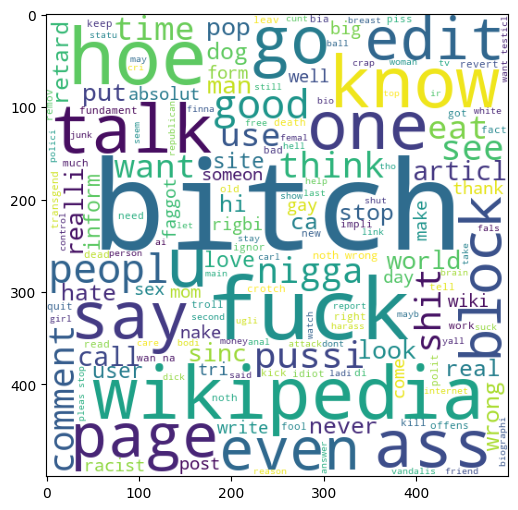

In [26]:
wc = WordCloud(width = 500, height = 500, min_font_size = 10, background_color = 'white')
profane_wc = wc.generate(df[df['target'] == 1]['content'].str.cat(sep = " "))
plt.figure(figsize = (15,6))
plt.imshow(profane_wc)
plt.show()

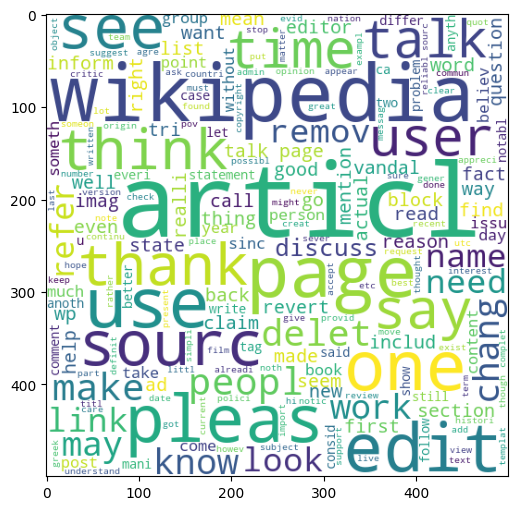

In [27]:
wc = WordCloud(width = 500, height = 500, min_font_size = 10, background_color = 'white')
sane_wc = wc.generate(df[df['target'] == 0]['content'].str.cat(sep = " "))
plt.figure(figsize = (15,6))
plt.imshow(sane_wc)
plt.show()

In [28]:
X = df['content']
y = df['target']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

X_train = tfidf.fit_transform(X_train).toarray()
X_test = tfidf.transform(X_test).toarray()

In [29]:
clfs = {
    'mnb': MultinomialNB(),
    'rfc': RandomForestClassifier(n_estimators=50, random_state=2),
    'knc': KNeighborsClassifier(),
    'hard-vote': VotingClassifier(
        estimators=[
            ('mnb', MultinomialNB()),
            ('rfc', RandomForestClassifier(n_estimators=50, random_state=2)),
            ('knc', KNeighborsClassifier(),)
        ],
        voting='hard'
    ),
    'soft-vote': VotingClassifier(
        estimators=[
            ('mnb', MultinomialNB()),
            ('rfc', RandomForestClassifier(n_estimators=50, random_state=2)),
            ('knc', KNeighborsClassifier())
        ],
        voting='soft',
    )
}

In [30]:
def train(name, model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_preds = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_preds)
    precision = precision_score(y_test, y_preds)
    print(f"{name} - accuracy: {accuracy:.2f} -- precision: {precision: .2f}")

In [31]:
for name, clf in clfs.items():
    train(name, clf, X_train, y_train, X_test, y_test)

mnb - accuracy: 0.93 -- precision:  0.94
rfc - accuracy: 0.94 -- precision:  0.85
knc - accuracy: 0.90 -- precision:  0.86
hard-vote - accuracy: 0.94 -- precision:  0.95
soft-vote - accuracy: 0.94 -- precision:  0.95


In [32]:
def test(text):
    txt = tfidf.transform([text])
    print("="*40)
    for name, clf in clfs.items():
        prediction = clf.predict(txt)
        # print(prediction)
        prediction = 'not-profane' if prediction == 0 else 'profane'
        print(f"{name} thinks '{text}' -> {prediction}")
        
testData = ["Hi Bruv, Hope you are doing well", "Love this product", "She's a hoe", 'Suck water from bottle', "write the article ibtch", "Idiot, A cup of cum for you! DRINK IT ALL PLZ", "A cup of cum for you! DRINK IT ALL PLZ"]

for text in testData:
    test(text)

mnb thinks 'Hi Bruv, Hope you are doing well' -> not-profane
rfc thinks 'Hi Bruv, Hope you are doing well' -> not-profane
knc thinks 'Hi Bruv, Hope you are doing well' -> not-profane
hard-vote thinks 'Hi Bruv, Hope you are doing well' -> not-profane
soft-vote thinks 'Hi Bruv, Hope you are doing well' -> not-profane
mnb thinks 'Love this product' -> not-profane
rfc thinks 'Love this product' -> not-profane
knc thinks 'Love this product' -> not-profane
hard-vote thinks 'Love this product' -> not-profane
soft-vote thinks 'Love this product' -> not-profane
mnb thinks 'She's a hoe' -> profane
rfc thinks 'She's a hoe' -> profane
knc thinks 'She's a hoe' -> profane
hard-vote thinks 'She's a hoe' -> profane
soft-vote thinks 'She's a hoe' -> profane
mnb thinks 'Suck water from bottle' -> not-profane
rfc thinks 'Suck water from bottle' -> not-profane
knc thinks 'Suck water from bottle' -> profane
hard-vote thinks 'Suck water from bottle' -> not-profane
soft-vote thinks 'Suck water from bottle' -